# Import libraries

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from ISLP.bart import BART


# Load Data

In [189]:
# Set pandas display options for better viewing
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

df=pd.read_csv('Ocean_Health_Index_2018_global_scores.csv')
print(df)

     OBJECTID rgn_typ  rgn_id              rgn_nam rgn_key       are_km2  \
0           1     eez       1        Cocos Islands     CCK  4.701166e+05   
1           2     eez      10                Nauru     NRU  3.105651e+05   
2           3     eez     100  Republique du Congo     COG  3.986360e+04   
3           4     eez     101              Namibia     NAM  5.627276e+05   
4           5     eez     102         South Africa     ZAF  1.069378e+06   
..        ...     ...     ...                  ...     ...           ...   
214       218     eez      95     Falkland Islands     FLK  5.490917e+05   
215       219     eez      96         Sierra Leone     SLE  1.604526e+05   
216       220     eez      97              Liberia     LBR  2.477677e+05   
217       221     eez      98                 Togo     TGO  1.552131e+04   
218       222     eez      99                Benin     BEN  3.041927e+04   

        AO     BD     CP     CS     CW     ECO    FIS     FP     HAB    ICO  \
0    96.

# Principal Component Analysis

Based on the PCA we decided to focus on the Clean Water as the most important feature

# Feature selection


In [246]:
model_numerical = df.select_dtypes(include=np.number)
model = MS(model_numerical.columns.drop(['CW', 'Shape__Area', 'Shape__Length', 'Index_', 'OBJECTID', 'rgn_id', 'LE']), intercept=False) ## drop the outcome variable
D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)

## Data Split for training and testing

In [248]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                model_numerical['CW'],
                                test_size=0.3,
                                random_state=0)

# Model Training : Decision tree regression

[Text(0.4230769230769231, 0.875, 'ECO <= 18.235\nsquared_error = 359.225\nsamples = 153\nvalue = 62.558'),
 Text(0.15384615384615385, 0.625, 'trnd_sc <= -2.39\nsquared_error = 132.661\nsamples = 13\nvalue = 91.023'),
 Text(0.28846153846153844, 0.75, 'True  '),
 Text(0.07692307692307693, 0.375, 'squared_error = 0.0\nsamples = 1\nvalue = 54.6'),
 Text(0.23076923076923078, 0.375, 'SPP <= 85.6\nsquared_error = 23.949\nsamples = 12\nvalue = 94.058'),
 Text(0.15384615384615385, 0.125, 'squared_error = 16.598\nsamples = 7\nvalue = 90.914'),
 Text(0.3076923076923077, 0.125, 'squared_error = 1.028\nsamples = 5\nvalue = 98.46'),
 Text(0.6923076923076923, 0.625, 'are_km2 <= 130649.277\nsquared_error = 298.04\nsamples = 140\nvalue = 59.915'),
 Text(0.5576923076923077, 0.75, '  False'),
 Text(0.5384615384615384, 0.375, 'SPP <= 83.155\nsquared_error = 244.276\nsamples = 55\nvalue = 52.163'),
 Text(0.46153846153846156, 0.125, 'squared_error = 207.834\nsamples = 25\nvalue = 42.836'),
 Text(0.615384615

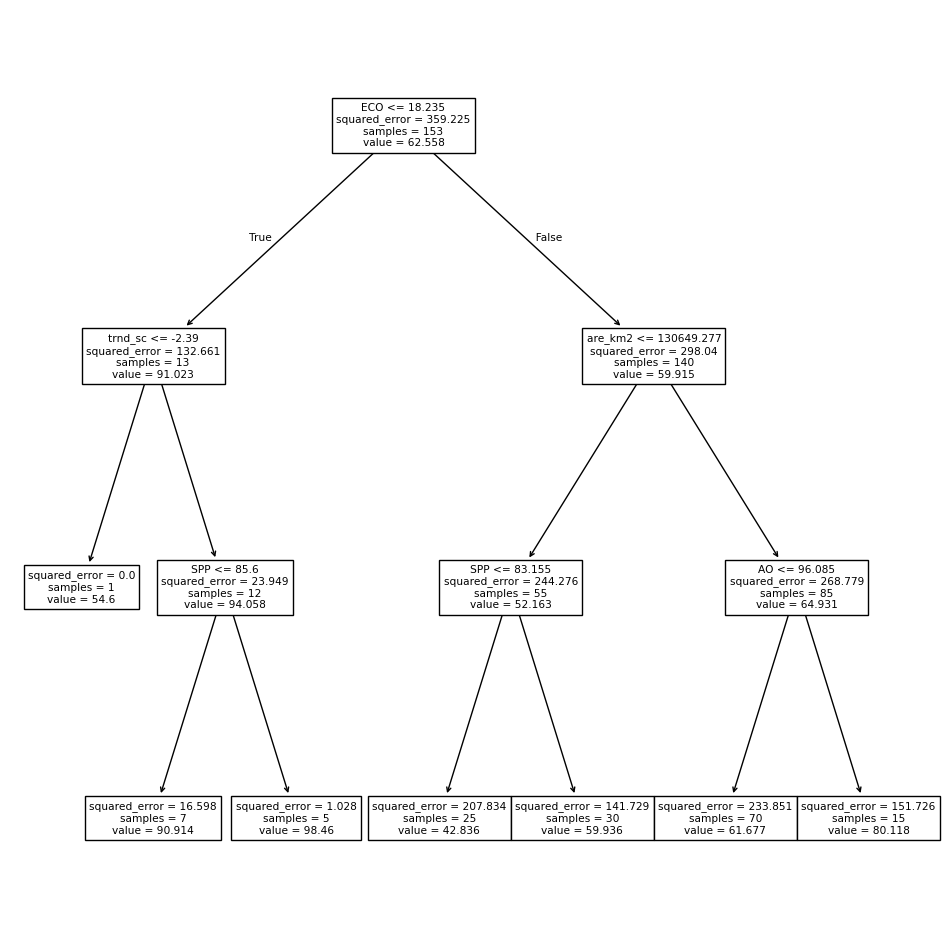

In [249]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax)

## DTR Model Evaluation : Assessing Test and Training Data


In [250]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [251]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

258.7929567758743

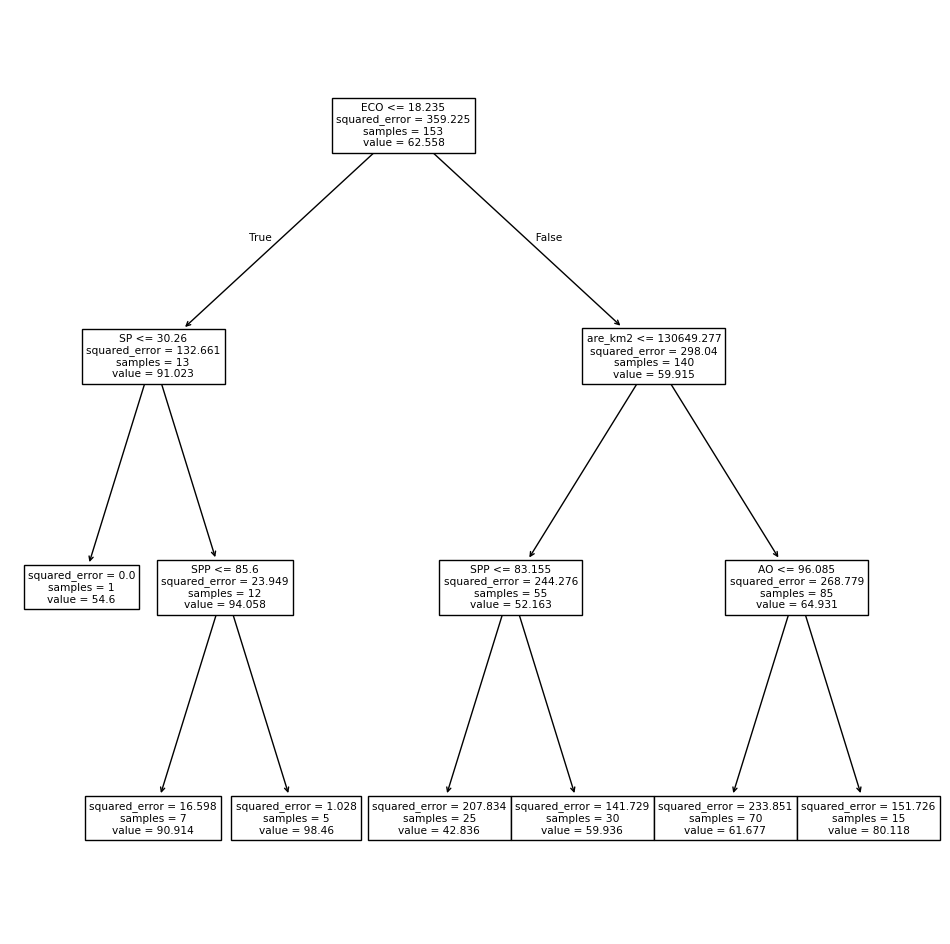

In [252]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);


## DTR : Importance of features


In [253]:
feature_imp = pd.DataFrame(
    {'importance':reg.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
ECO,0.430375
are_km2,0.203545
AO,0.157058
SPP,0.155289
trnd_sc,0.053733
CS,0.000000
FIS,0.000000
FP,0.000000
HAB,0.000000
CP,0.000000


# Bagging and Random Forests


## Model Training

In [197]:
bag_ocean = RF(max_features=X_train.shape[1], random_state=0)
bag_ocean.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,18
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


117.72085138318182

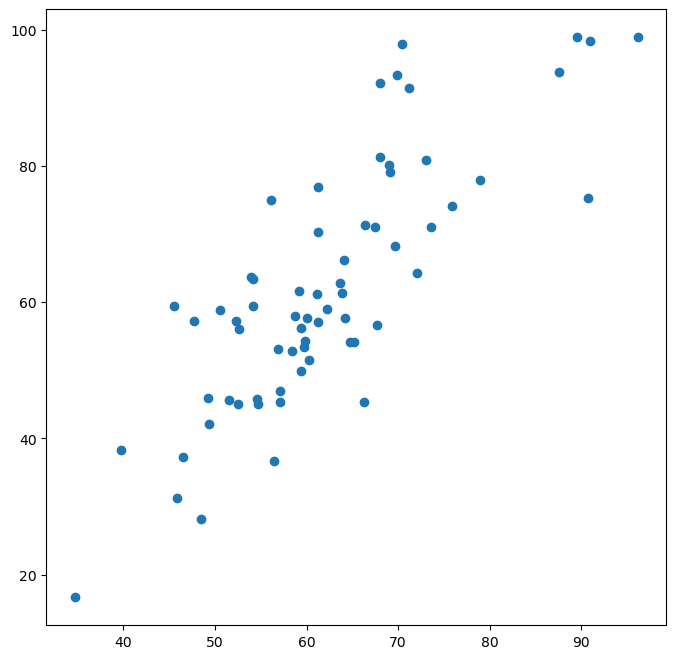

In [213]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_ocean.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

In [199]:
bag_ocean = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_ocean.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

121.26420987783051

In [212]:
bag_ocean = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = bag_ocean.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

117.72085138318182

In [211]:
feature_imp = pd.DataFrame(
    {'importance':bag_ocean.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
are_km2,0.135295
ECO,0.101379
LIV,0.095261
AO,0.083968
BD,0.073504
TR,0.072595
CS,0.069398
SPP,0.064585
HAB,0.041797
FP,0.033750


# Boosting

## Model Training

In [222]:
boost_ocean = GBR(n_estimators=500,
                   learning_rate=0.001,
                   max_depth=5,
                   random_state=0)
boost_ocean.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.001
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


Text(0.5, 1.0, 'Gradient Boosting Regressor : n_estimators=500, learning_rate=0.001, max_depth=5, random_state=0)')

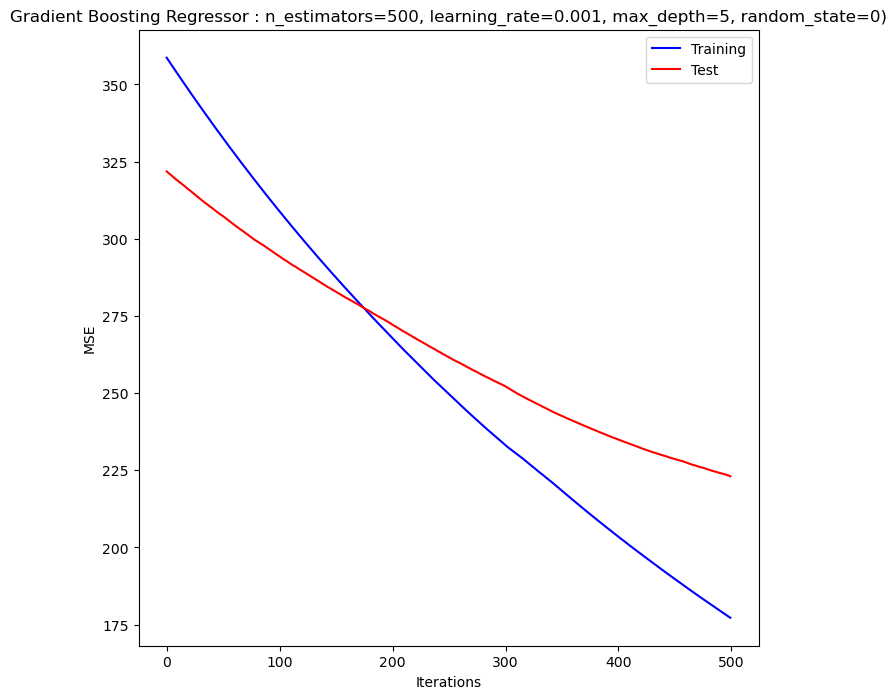

In [223]:
test_error = np.zeros_like(boost_ocean.train_score_)
for idx, y_ in enumerate(boost_ocean.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_ocean.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_ocean.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("MSE")
ax.set_title("Gradient Boosting Regressor : n_estimators=500, learning_rate=0.001, max_depth=5, random_state=0)")

In [224]:
y_hat_boost = boost_ocean.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

223.05926766644734

In [254]:
boost_ocean = GBR(n_estimators=200,
                   learning_rate=0.2,
                   max_depth=5,
                   random_state=0)
boost_ocean.fit(X_train,
                 y_train)
y_hat_boost = boost_ocean.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

121.21037082594408

In [255]:
feature_imp = pd.DataFrame(
    {'importance':bag_ocean.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
are_km2,0.135295
ECO,0.101379
LIV,0.095261
AO,0.083968
BD,0.073504
TR,0.072595
CS,0.069398
SPP,0.064585
HAB,0.041797
FP,0.033750


Text(0.5, 1.0, 'Gradient Boosting Regressor : n_estimators=200, learning_rate=0.2, max_depth=5, random_state=0)')

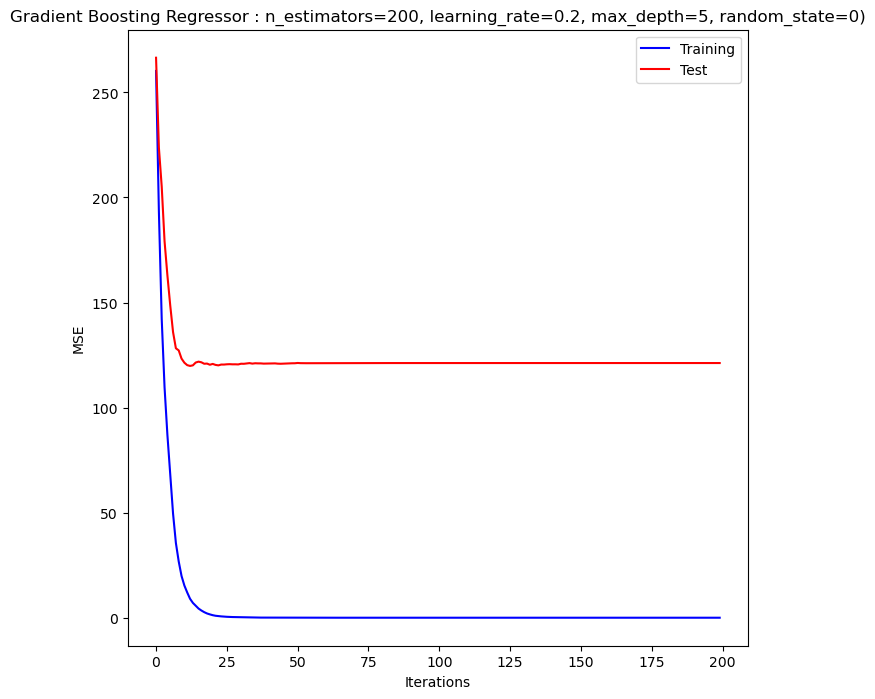

In [256]:
test_error = np.zeros_like(boost_ocean.train_score_)
for idx, y_ in enumerate(boost_ocean.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_ocean.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_ocean.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("MSE")
ax.set_title("Gradient Boosting Regressor : n_estimators=200, learning_rate=0.2, max_depth=5, random_state=0)")


## Data Visualisation of One tree

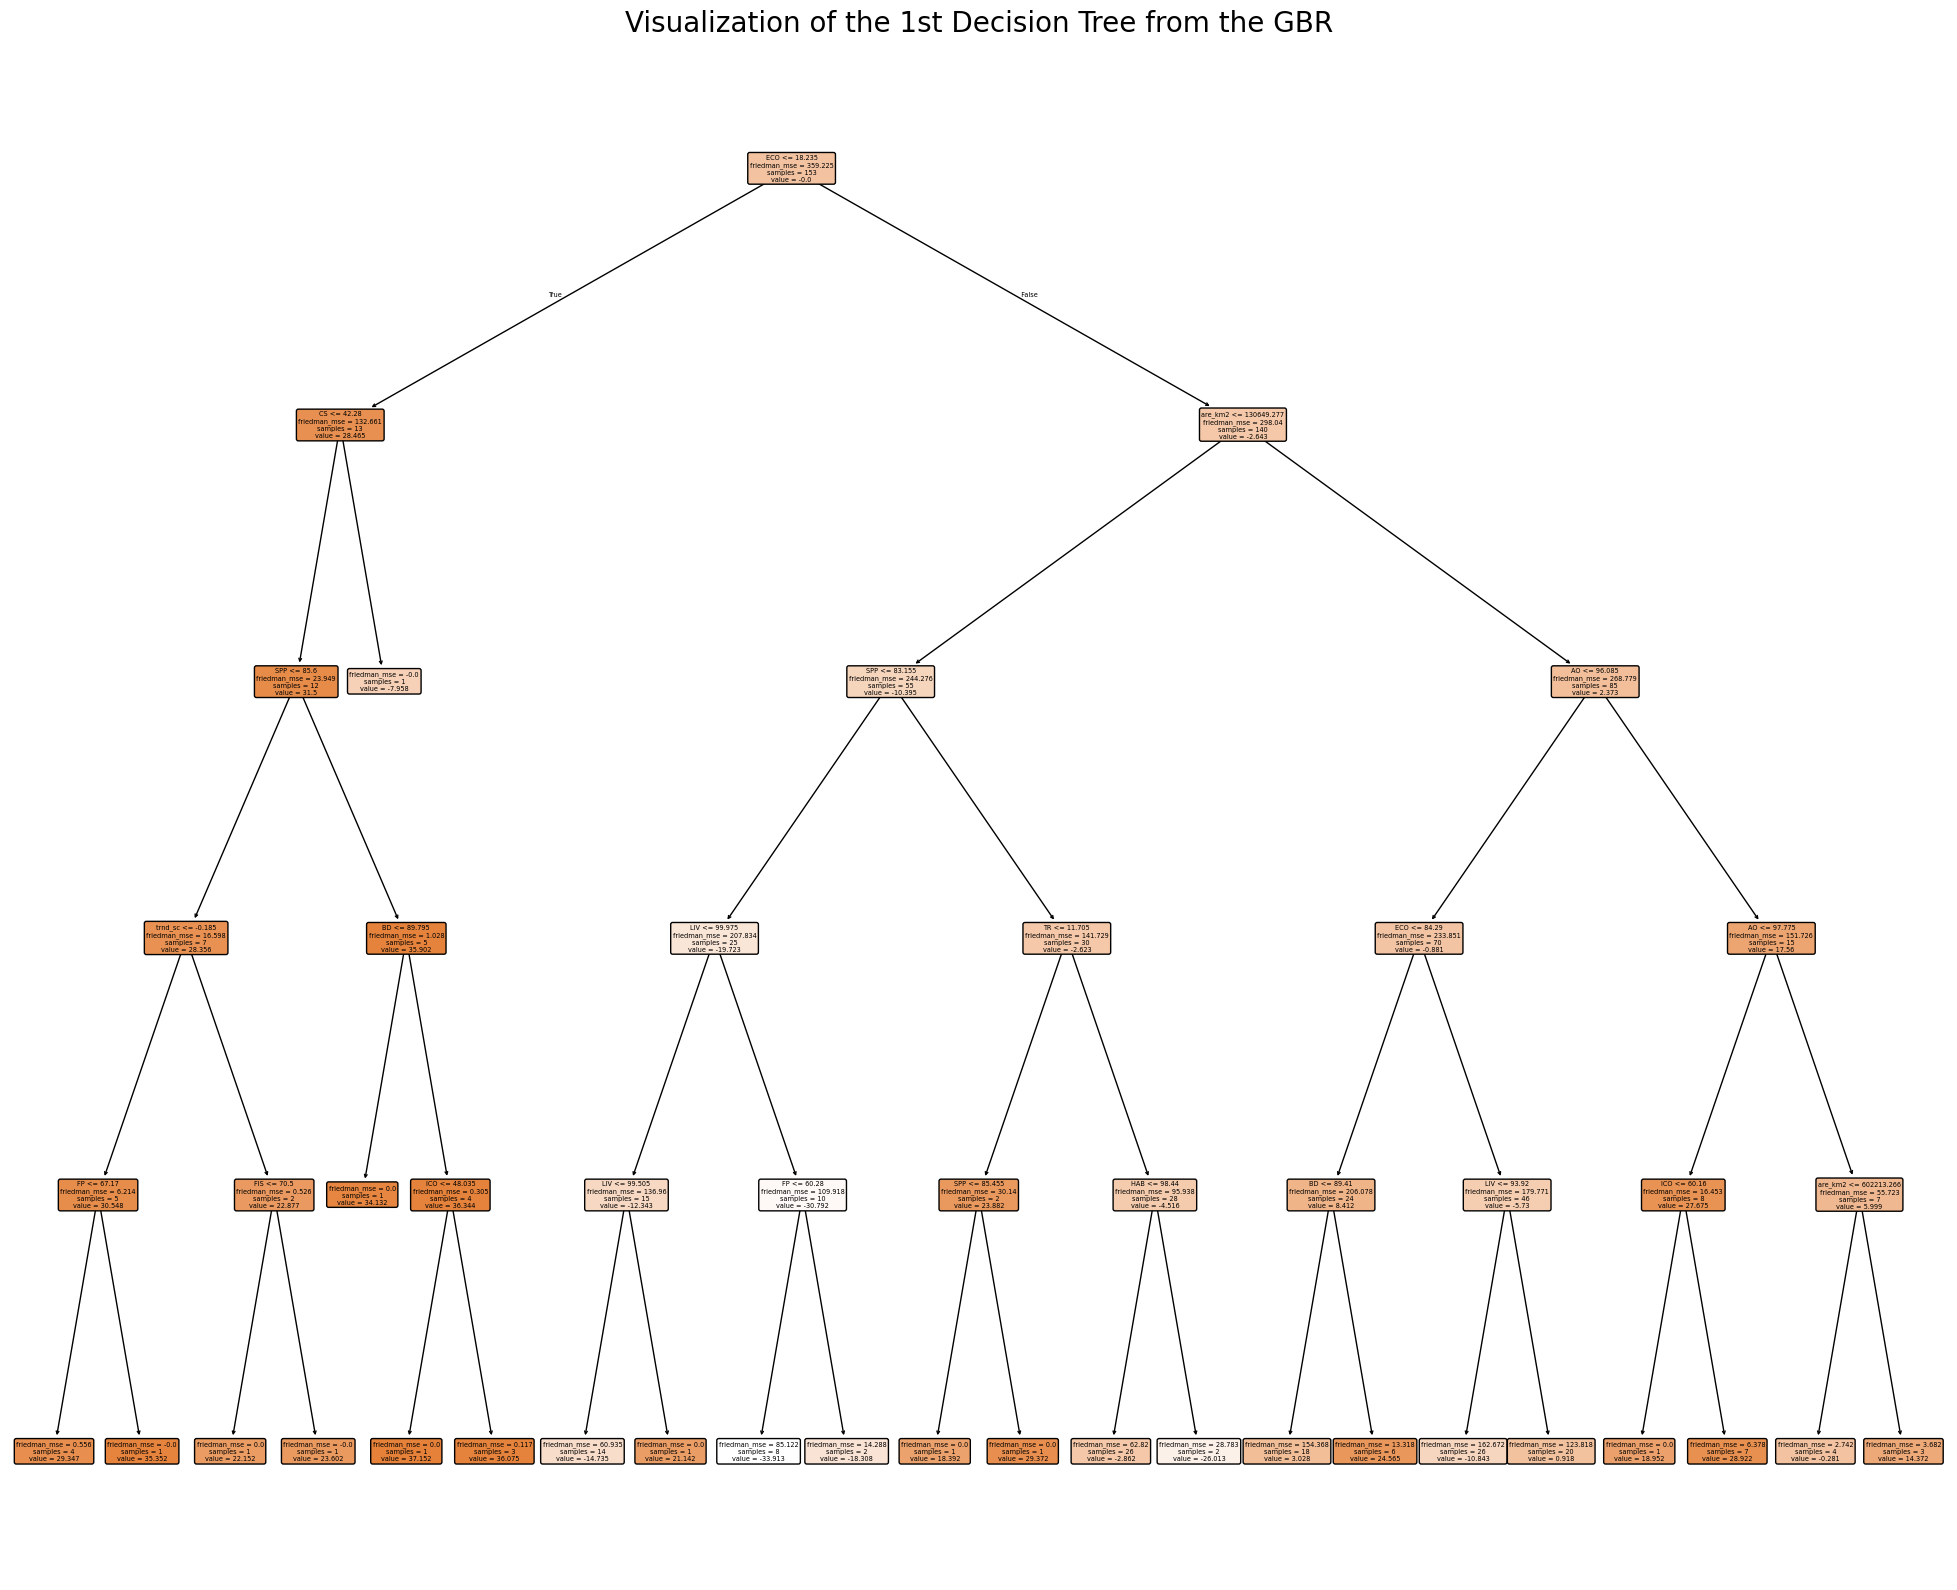

In [260]:
single_tree_from_gbr = boost_ocean.estimators_[0][0]

plt.figure(figsize=(25, 20))
plot_tree(single_tree_from_gbr,
          feature_names=feature_names,
          filled=True,
          rounded=True)

plt.title("Visualization of the 1st Decision Tree from the GBR", fontsize=20)
plt.show()

# Bayesian Additive Regression Tree

In [185]:
bart_ocean = BART(random_state=0, burnin=40, ndraw=15)
bart_ocean.fit(X_train, y_train)

,num_trees,200
,num_particles,10
,max_stages,5000
,split_prob,<function BAR...00247CF1B7D80>
,min_depth,0
,std_scale,2
,split_prior,None
,ndraw,15
,burnin,40
,sigma_prior,"(5, ...)"
,num_quantile,50


In [186]:
yhat_test = bart_ocean.predict(X_test.astype(np.float32))

np.mean((y_test - yhat_test)**2)

136.6158151260697

In [187]:
var_inclusion = pd.Series(bart_ocean.variable_inclusion_.mean(0),
                               index=D.columns)
var_inclusion
var_inclusion.sort_values(ascending=False)

are_km2    20.000000
ECO        18.666667
BD         18.600000
MAR        18.133333
CP         17.933333
CS         17.866667
FP         16.600000
ICO        16.400000
SPP        16.266667
LSP        16.133333
FIS        16.000000
TR         15.933333
LIV        15.800000
NP         15.600000
AO         15.400000
HAB        15.333333
SP         14.533333
trnd_sc    13.533333
dtype: float64